In [1]:
from RNN_QSR import *

cuda:0


In [2]:
class RNNTransformer(Sampler):
    def __init__(self,Lx,Ly,device=device,Nh=128,decoder=False,dropout=0.0,num_layers=3, **kwargs):
        super(RNNTransformer, self).__init__(device=device)
                
        if decoder:
            #Decoder only transformer
            self.decoder_layer = nn.TransformerDecoderLayer(d_model=Nh, nhead=8, dropout=dropout)
            self.transformer = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        else:
            #Encoder only transformer
            #misinterperetation on encoder made it so this code does not work
            self.encoder_layer = nn.TransformerEncoderLayer(d_model=Nh, nhead=8, dropout=dropout)
            self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        
        self.lin = nn.Sequential(
                nn.Linear(Nh,Nh),
                nn.ReLU(),
                nn.Linear(Nh,1),
                nn.Sigmoid()
            )
        self.Nh=Nh
        #rnn to encode the input for the transformer
        self.rnn = nn.GRU(input_size=1,hidden_size=Nh,batch_first=False)
        
        self.set_mask(Lx*Ly)
        self.to(device)
        self.init_weights()

    def init_weights(self):
        self.num_weights = sum (p.numel () for p in self.parameters ())
        print("Initializing. . .",self.num_weights)
        stdv=10/np.sqrt(self.num_weights)
        for weight in self.parameters():
            nn.init.normal_(weight, mean=0.0,std= stdv)
        
    def forward(self, input):
        # input is shape [B,L,1]
        # add positional encoding to get shape [B,L,Nh]
        if input.shape[1]!=self.L:
            self.set_mask(input.shape[1])
        h0=torch.zeros([1,input.shape[0],self.Nh],device=self.device)
        #using an rnn to (positionally) encode the input sequence
        encoded,h=self.rnn(input.transpose(1,0),h0)
        #apply self attention
        output = self.transformer(encoded,self.mask)
        output = self.lin(output.transpose(1,0))
        return output
    
    
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        
        #Input should have shape [B,L,1]
        B,L,one=input.shape
        
        #first prediction is with the zero input vector
        data=torch.zeros([B,L,one],device=self.device)
        #data is the input vector shifted one to the right, with the very first entry set to zero instead of using pbc
        data[:,1:,:]=input[:,:-1,:]
        #real is going to be a set of actual values
        real=input
        #and pred is going to be a set of probabilities
        #if real[i]=1 than you multiply your conditional probability by pred[i]
        #if real[i]=0 than you multiply by 1-pred[i]
        pred = self.forward(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
        #this is the sum you see in the cell above
        #add 1e-10 to the prediction to avoid nans when total=0
        logp=torch.sum(torch.log(total+1e-10),dim=1).squeeze(1)
        return logp

    def _off_diag_labels(self,sample,B,L,grad,D=1): #_off_diag_labels
        """label all of the flipped states  - set D as high as possible without it slowing down runtime"""
        sflip = torch.zeros([B,L,L,1],device=self.device)
        #collect all of the flipped states into one array
        for j in range(L):
            #get all of the states with one spin flipped
            sflip[:,j] = sample*1.0
            sflip[:,j,j] = 1-sflip[:,j,j]
        #compute all of their logscale probabilities
        with torch.no_grad():
            #prepare sample to be used as cache
            B,L,one=sample.shape
            dsample=torch.zeros([B,L,one],device=self.device)
            dsample[:,1:,:]=sample[:,:-1,:]

            h_00 = torch.zeros([1,B,self.Nh],device=self.device)
            encoded,_ = self.rnn(dsample.transpose(1,0),h_00) 
            
            hstates=torch.zeros([D,1,B,self.Nh],device=self.device)
            #get the hidden states at each batched point of the sequence
            hstates[1:,0]=encoded[L//D-1:-L//D:L//D]
            
            #add positional encoding and make the cache
            out,cache=self.make_cache(encoded)

            probs=torch.zeros([B,L],device=self.device)

            #expand cache to group L//D flipped states
            cache=cache.unsqueeze(2)

            #this line took like 1 hour to write I'm so sad
            #the cache has to be shaped such that the batch parts line up
            cache=cache.repeat(1,1,L//D,1,1).transpose(2,3).reshape(cache.shape[0],L,B*L//D,cache.shape[-1])
            #repeat the same way for hstates
            hstates = hstates.repeat(1,L//D,1,1).transpose(1,2).reshape(D,B*L//D,self.Nh)
            
            encoded=encoded.unsqueeze(1).repeat(1,L//D,1,1).transpose(2,1).reshape(L,B*L//D,self.Nh)
            
            pred0 = self.lin(out.transpose(1,0))
            ones = sample*pred0
            zeros=(1-sample)*(1-pred0)
            total0 = ones+zeros

            for k in range(D):

                N = k*L//D
                #next couple of steps are crucial          
                #get the samples from N to N+L//D
                #Note: samples are the same as the original up to the Nth spin
                real = sflip[:,N:(k+1)*L//D]
                #this is slightly wasteful because you can just look at the tensors from N forward
                #flatten it out 
                tmp = real.reshape([B*L//D,L,1])
                #set up next state predction
                fsample=torch.zeros(tmp.shape,device=self.device)
                fsample[:,1:,:]=tmp[:,:-1,:]
                
                new_encode,_=self.rnn(fsample[:,N:].transpose(1,0),hstates[k:k+1])
                tgt = torch.cat([encoded[:N], new_encode], dim=0)
                #tgt,_ = self.rnn(fsample.transpose(1,0),hstates[0:1])
                                
                #grab your transformer output
                out,_=self.next_with_cache(tgt,cache[:,:N],N)

                # self.lin actually does some repeated work but it's probably
                # negligable compared to the time attention takes
                output = self.lin(out[N:].transpose(1,0))
                # reshape output separating batch from spin flip grouping
                pred = output.view([B,L//D,L-N,1])
                real=real[:,:,N:]
                ones = real*pred
                zeros=(1-real)*(1-pred)
                total = ones+zeros
                #sum across the sequence for probabilities
                logp=torch.sum(torch.log(total+1e-10),dim=2).squeeze(2)
                logp+=torch.sum(torch.log(total0[:,:N]+1e-10),dim=1)
                probs[:,N:(k+1)*L//D]=logp
                
        return sample,probs
    def next_attn(_,tgt,layer,i=-1):
        """Calculates self attention with tgt and the last elem of tgt
        Inputs: 
            tgt - Tensor of shape [L+1,B,1]
            layer - TransformerDecoderLayer
            i - index of the first bit we want self-attention from
        Outputs:
            Tensor of shape [1,B,1]
        """
        src = tgt[i:, :, :]
        mask = None if i==-1 else _.mask[i:]
        # self attention part
        src2 = layer.self_attn(
            src,#only do attention with the last elem of the sequence
            tgt,
            tgt,
            attn_mask=mask,  # not needed because we only care about the last token
            key_padding_mask=None,
        )[0]
        #straight from torch transformer encoder code
        src = src + layer.dropout1(src2)
        src = layer.norm1(src)
        src2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(src))))
        src = src + layer.dropout2(src2)
        src = layer.norm2(src)
        return src
    
    def next_with_cache(self,tgt,cache=None,idx=-1):
        """Efficiently calculates the next output of a transformer given the input sequence and 
        cached intermediate layer encodings of the input sequence
        
        Inputs:
            tgt - Tensor of shape [L,B,1]
            cache - Tensor of shape ?
            idx - index from which to start
            
        Outputs:
            output - Tensor of shape [?,B,1]
            new_cache - Tensor of shape ?
        """
        output = tgt
        new_token_cache = []
        #go through each layer and apply self attention only to the last input
        for i, layer in enumerate(self.transformer.layers):
            output = self.next_attn(output,layer,idx)
            new_token_cache.append(output)
            if cache is not None:
                #layers after layer 1 need to use a cache of the previous layer's output on each input
                output = torch.cat([cache[i], output], dim=0)

        #update cache with new output
        if cache is not None:
            new_cache = torch.cat([cache, torch.stack(new_token_cache, dim=0)], dim=1)
        else:
            new_cache = torch.stack(new_token_cache, dim=0)

        return output, new_cache
    
    def make_cache(self,tgt):
        output = tgt
        new_token_cache = []
        #go through each layer and apply self attention only to the last input
        for i, layer in enumerate(self.transformer.layers):
            output = layer(output,src_mask=self.mask)#self.next_attn(output,layer,0)
            new_token_cache.append(output)
        #create cache with tensor
        new_cache = torch.stack(new_token_cache, dim=0)
        return output, new_cache
    
    def set_mask(self, L):
        # take the log of a lower triangular matrix
        self.L=L
        self.mask = torch.log(torch.tril(torch.ones(L,L))).to(device)
    
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        #return (torch.rand([B,L,1],device=device)<0.5).to(torch.float32)
        #Sample set will have shape [B,L,1]
        #need one extra zero batch at the start for first pred hence input is [L+1,B,1] 
        #transformers don't do batch first so to save a bunch of transpose calls 
        input = torch.zeros([L+1,B,1],device=self.device)
        #self.set_mask(L)
        h=torch.zeros([1,B,self.Nh],device=self.device)
        #using an rnn to (positionally) encode the input sequence
        encoded_input=torch.zeros([L,B,self.Nh],device=self.device)
        
        cache=None
        with torch.no_grad():
          for idx in range(1,L+1):
            #run the rnn on shape [B,1,1]   
            #append new encoding from the rnn
            encoded_input[idx-1:idx],h = self.rnn(input[idx-1:idx],h)
                        
            #Get transformer output
            output,cache = self.next_with_cache(encoded_input[:idx],cache)
            #if probs[i]=1 then there should be a 100% chance that sample[i]=1
            #if probs[i]=0 then there should be a 0% chance that sample[i]=1
            #stands that we generate a random uniform u and take int(u<probs) as our sample
            probs=self.lin(output[-1,:,:])
            sample = (torch.rand([B,1],device=device)<probs).to(torch.float32)
            input[idx,:,:]=sample
        #input's first entry is zero to get a predction for the first atom
        #print(".",end="")
        return input.transpose(1,0)[:,1:,:]

In [3]:
#Settings
op=Opt()
Lx=8
op.L=Lx*Lx
op.Nh=128
op.lr=5e-4
op.Q=1
op.K=32
op.USEQUEUE=0
#op.apply(sys.argv[1:])
op.B=op.K*op.Q
print(op)

L                             			64
Q                             			1
K                             			32
B                             			32
TOL                           			0.15
M                             			0.96875
USEQUEUE                      			0
NLOOPS                        			1
hamiltonian                   			Rydberg
steps                         			12000
dir                           			out
Nh                            			128
lr                            			0.0005



In [4]:
trainsformer = RNNTransformer(Lx,Lx,Nh=op.Nh,num_layers=1)
sampleformer= RNNTransformer(Lx,Lx,Nh=op.Nh,num_layers=1)
beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
trainsformer.parameters(), 
lr=op.lr, 
betas=(beta1,beta2)
)

0.00012640096247196198 1.080641587473709
tensor(0.0008, device='cuda:0')


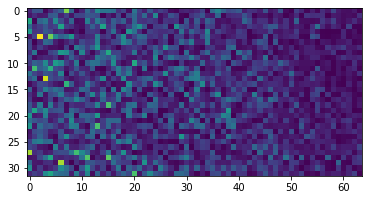

In [5]:
B=32

s = trainsformer.sample(B,op.L)

probs = super(RNNTransformer,trainsformer)._off_diag_labels(s,B,op.L,False,D=1)[1]

p2 = trainsformer._off_diag_labels(s,B,op.L,False,D=8)[1]

print(abs(probs-p2).mean().item(),torch.var_mean(probs)[0].item()**0.5)
print(abs(probs-p2).max())
plt.imshow(abs(probs-p2).cpu())

In [5]:
op.dir="HYBRID"
#op.steps=100
op.NLOOPS=16
if op.USEQUEUE:
    queue_train(op,(trainsformer,sampleformer,optimizer))
else:
    print("Training. . .")
    reg_train(op,(trainsformer,optimizer))

Training. . .
Output folder path established
-0.40522 64
0,2.51|48,-0.31|96,-0.34|144,-0.38|191,-0.39|239,-0.39|287,-0.38|335,-0.38|383,-0.39|431,-0.39|480,-0.39|532,-0.39|585,-0.40|638,-0.39|691,-0.40|743,-0.40|796,-0.39|849,-0.39|901,-0.39|954,-0.39|1007,-0.39|1059,-0.39|1112,-0.40|1164,-0.39|1212.0738739967346 12000
